In [22]:
import os
from datetime import datetime
import pytz
import csv
import cv2
import pandas as pd
from ultralytics import YOLO
from dateutil import parser
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import logging
import numpy as np



In [23]:

def extract_datetime_from_filename(filename):
    """Extracts the timestamp from the image filename."""
    name, _ = os.path.splitext(filename)
    date_part = name.split('_')[-1]
    try:
        timestamp = datetime.strptime(date_part, "%Y%m%d%H%M%S")
        utc_timezone = pytz.utc
        timestamp_utc = utc_timezone.localize(timestamp)
        est_timezone = pytz.timezone('America/New_York')
        timestamp_est = timestamp_utc.astimezone(est_timezone)
        return timestamp_est
    except ValueError as e:
        print(f"Error parsing date from filename {filename}: {e}")
        return None


def parse_csv(file_path):
    """Parses a CSV with event numbers, start, and end times to create a list of events."""
    events = []
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            event_id = int(row['flood_event'])
            start_time = parser.parse(row['start_time_EST'])
            end_time = parser.parse(row['end_time_EST'])
            est = pytz.timezone('America/New_York')
            if start_time.tzinfo is None:
                start_time = est.localize(start_time, is_dst=False)
            if end_time.tzinfo is None:
                end_time = est.localize(end_time, is_dst=False)
            events.append({
                'event_id': event_id,
                'start_time': start_time,
                'end_time': end_time
            })
    return events


def process_folder(folder_path, events):
    """Sorts images into events based on their timestamps extracted from filenames."""
    files = os.listdir(folder_path)
    timestamps_dict = {}
    
    for file in files:
        timestamp = extract_datetime_from_filename(file)
        if timestamp:
            timestamps_dict[file] = timestamp
        else:
            print(f"Failed to extract datetime from filename: {file}")
    
    event_images = {event['event_id']: [] for event in events}
    event_images[1000] = []  # For images outside any event

    for file, timestamp in timestamps_dict.items():
        assigned = False
        for event in events:
            if event['start_time'] <= timestamp <= event['end_time']:
                event_images[event['event_id']].append(file)
                assigned = True
                break
        if not assigned:
            event_images[1000].append(file)
    
    return event_images


def copy_and_rename_files_with_event_numbers(folder_path, event_images, new_folder_path):
    """Copies and renames files by appending the event number to the filenames."""
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)
    
    for event_id, files in event_images.items():
        for file in files:
            old_file_path = os.path.join(folder_path, file)
            new_file_name = f"{os.path.splitext(file)[0]}_event{event_id}{os.path.splitext(file)[1]}"
            new_file_path = os.path.join(new_folder_path, new_file_name)
            shutil.copy2(old_file_path, new_file_path)


def count_objects_in_folder(folder_path):
    """Counts objects in all images within a folder and returns the counts per image, also saves bounding box data."""

    # Disable YOLO internal logging
    logging.getLogger('ultralytics').setLevel(logging.CRITICAL)
    model = YOLO("yolo11x.pt", verbose=False)  # Suppress verbose logging
    
    # Classes to look for (based on COCO dataset class IDs)
    CLASS_IDS = {
        'car': 2,
        'truck': 7,
        'motorcycle': 3,
        'bicycle': 1,
        'person': 0
    }

    # Dictionary to store counts for each image
    folder_counts = {}

    # List to accumulate bounding box data for all images
    all_bbox_data = []

    # Get the list of image files in the folder
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Progress bar for processing images
    with tqdm(total=len(files), desc="Processing Images", disable=False) as pbar:
        # Loop through all image files in the folder
        for filename in files:
            image_path = os.path.join(folder_path, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Check if the image was loaded correctly
            if image is None:
                pbar.update(1)  # Update the progress bar even if there's an error
                continue
            
            # Convert the image to RGB (YOLO models typically expect RGB images)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Perform inference
            results = model(image_rgb)

            # Check if results are a list and access the first result
            if isinstance(results, list) and len(results) > 0:
                results = results[0]  # Get the first result

            # Initialize counters for each class
            counts = {key: 0 for key in CLASS_IDS.keys()}

            # Check if detections exist and iterate over them
            if hasattr(results, 'boxes') and results.boxes is not None:
                for box in results.boxes:
                    # Get class ID of detected object
                    class_id = int(box.cls)
                    
                    # Retrieve bounding box coordinates (xmin, ymin, xmax, ymax)
                    xmin, ymin, xmax, ymax = map(int, box.xyxy[0])  # Convert to integer values if needed

                    # Match class ID with class name and count occurrences
                    for key, value in CLASS_IDS.items():
                        if class_id == value:
                            counts[key] += 1
                            # Add bounding box data to list
                            all_bbox_data.append({
                                'image': filename,
                                'class': key,
                                'class_id': class_id,
                                'xmin': xmin,
                                'ymin': ymin,
                                'xmax': xmax,
                                'ymax': ymax
                            })

            # Store the counts for this image
            folder_counts[filename] = counts

            # Update the progress bar after each image is processed
            pbar.update(1)

    # Export all bounding box data to a CSV file with bounding boxes for each image
    df_bbox = pd.DataFrame(all_bbox_data)
    df_bbox.to_csv('bounding_boxes.csv', index=False)

    return folder_counts


def object_counts_to_csv(image_directory):
    """Saves object counts for each image and its event number into a CSV."""
    folder_counts = count_objects_in_folder(image_directory)
    results_list = []
    
    for filename, counts in folder_counts.items():
        event_number = filename.split('_event')[-1].split('.')[0] if '_event' in filename else "unknown"
        counts['image'] = filename
        counts['event_number'] = event_number
        results_list.append(counts)

    df = pd.DataFrame(results_list)
    df.to_csv("object_counts.csv", index=False)


def plot_from_df(csv_to_be_plotted):
    """Plots object counts per event from a CSV file."""
    object_df = pd.read_csv(csv_to_be_plotted)
    summed_df = object_df.groupby('event_number').sum()
    summed_df['Total Objects'] = (summed_df['car'] + summed_df['truck'] + 
                                  summed_df['motorcycle'] + summed_df['bicycle'] + summed_df['person'])
    summed_df = summed_df.reset_index()
    summed_df = summed_df[summed_df['event_number'] != '1000']
    
    x_values = range(len(summed_df))
    plt.figure(figsize=(12, 6))
    plt.scatter(x_values, summed_df['Total Objects'], color='coral', marker='o')
    plt.xlabel('Event Number')
    plt.xticks(x_values, summed_df['event_number'])
    plt.ylabel('Total Objects')
    plt.title('Total Objects by Event Number')
    plt.grid(True)
    plt.show()

def overlay_bounding_boxes(yolo_folder_path, output_folder, bbox_csv_path):
    """Overlays bounding boxes from a CSV onto images and saves them in a new directory."""

    # Load bounding box data from CSV
    bbox_data = pd.read_csv(bbox_csv_path)

    # Create the output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image in the bounding box data
    for filename in bbox_data['image'].unique():
        image_path = os.path.join(yolo_folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        
        # Check if the image was loaded correctly
        if image is None:
            print(f"Warning: {filename} could not be loaded.")
            continue
        
        # Filter bounding boxes for the current image
        image_bboxes = bbox_data[bbox_data['image'] == filename]

        # Draw each bounding box on the image
        for _, row in image_bboxes.iterrows():
            # Get bounding box coordinates and class label
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            class_name = row['class']

            # Draw the bounding box in red
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  # Red box with 2-pixel thickness
            
            # Add class label text above the bounding box with adjusted font size
            label = f"{class_name}"
            font_scale = 3  # Slightly smaller font scale
            font_thickness = 3  # Thicker text for bolder white text
            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
            label_ymin = max(ymin, label_size[1] + 10)
            
            # Draw the red background rectangle for the label
            cv2.rectangle(
                image,
                (xmin, label_ymin - label_size[1] - 10),
                (xmin + label_size[0], label_ymin + 5),
                (0, 0, 255),  # Red background
                -1  # Filled rectangle
            )
            
            # Draw the white text label with bolder thickness
            cv2.putText(
                image,
                label,
                (xmin, label_ymin - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),  # White text
                font_thickness
            )

        # Save the annotated image to the output directory
        cv2.imwrite(output_path, image)
    
    print("Bounding boxes overlayed and images saved successfully.")

    

    

Error parsing date from filename output_folder: time data 'folder' does not match format '%Y%m%d%H%M%S'
Failed to extract datetime from filename: output_folder
Error parsing date from filename output_folder_v11: time data 'v11' does not match format '%Y%m%d%H%M%S'
Failed to extract datetime from filename: output_folder_v11
Error parsing date from filename Updated_Files: time data 'Files' does not match format '%Y%m%d%H%M%S'
Failed to extract datetime from filename: Updated_Files


Processing Images: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]


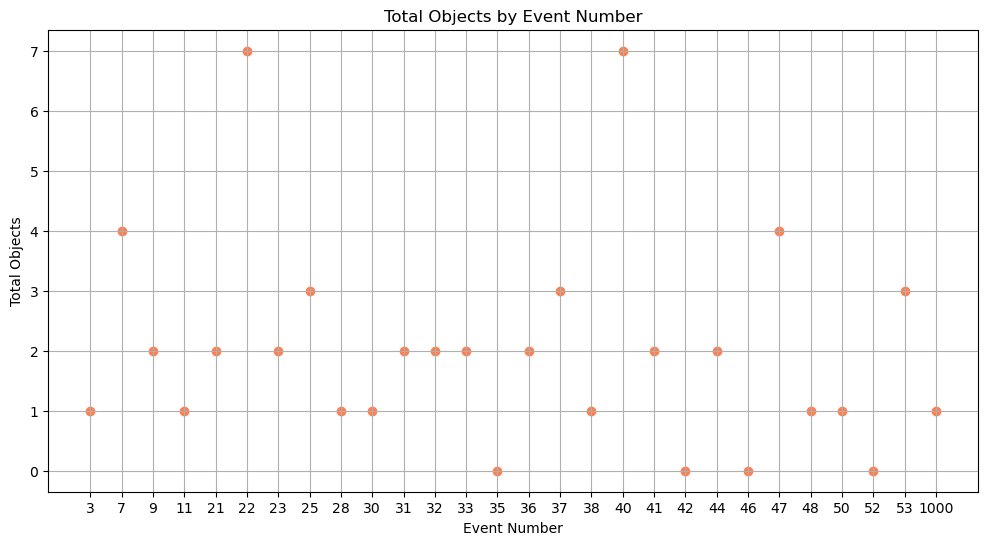

Bounding boxes overlayed and images saved successfully.


In [24]:
# Necessary Variables here: 

# Set folder path with folder location containing images to be processed (subjected to object counting)
folder_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Water_Quality_Images\Scripts\Sample Images"

# Set file path to file containing flood event numbers, start and end times
csv_file_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Water_Quality_Images\Scripts\abbr_flood_events.csv"

# Set bounding box information paths for the output csv and where the output images should be stored
bbox_csv_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Water_Quality_Images\Scripts\bounding_boxes.csv"
bbox_output = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Water_Quality_Images\Scripts\Sample Images\output_folder_v11"

# Set new file path for folder containing updated file names (with event number appended)
new_folder_path = os.path.join(folder_path, "Updated_Files")  # New folder path

# Parse events from CSV
events = parse_csv(csv_file_path)

# Process folder and sort images into events
event_images = process_folder(folder_path, events)

images_for_yoloing = copy_and_rename_files_with_event_numbers(folder_path, event_images, new_folder_path)


# Set folder path for images to be counted (add updated file )
yolo_folder_path = os.path.join(folder_path, "Updated_Files")

# Name of CSV to be plotted
csv_to_be_plotted = "object_counts.csv"

object_counts_to_csv(yolo_folder_path)

plot_from_df(csv_to_be_plotted)

#Overlay bounding boxes
overlay_bounding_boxes(yolo_folder_path, bbox_output, bbox_csv_path)
